In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.optimizers import adam_v2
# import transbigdata as tbd
import warnings


In [3]:
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [4]:
def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance

def createSequence(data, window=10, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['mmsi']):
        data_temp = data.loc[data.mmsi == traj_id]
        first_lon = data_temp.loc[0, 'lon']
        first_lat = data_temp.loc[0, 'lat']
        end_lon = data_temp.loc[data_temp.shape[0] - 1, 'lon']
        end_lat = data_temp.loc[data_temp.shape[0] - 1, 'lat']

        data_temp = np.array(data_temp.loc[:, ['lon', 'lat', 'sog', 'cog']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label

# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

In [5]:
# def trainModel(train_X, train_Y, test_X, test_Y):
#     model = Sequential()
#     model.add(LSTM(108, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
#     # model.add(Dropout(0.3))
#     model.add(Dense(train_Y.shape[1]))
#     model.add(Activation("relu"))
#     adam = adam_v2.Adam(learning_rate=0.01)
#     model.compile(loss='mse', optimizer=adam, metrics=['acc'])
#     log = CSVLogger(f"./log.csv", separator=",", append=True)
#     reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1,
#                                mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)

#     model.fit(train_X, train_Y, epochs=20, batch_size=32, verbose=1, validation_split=0.1,
#                   callbacks=[log, reduce])
#     loss, acc = model.evaluate(test_X, test_Y, verbose=1)
#     print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
#     model.save(f"./model.h5")
#     # 打印神经网络结构，统计参数数目
#     model.summary()
#     return model

In [6]:
from keras.layers import GRU
from keras.layers import Bidirectional


def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()
    model.add(Bidirectional(GRU(108, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False)))
    # model.add(Dropout(0.3))
    model.add(Dense(train_Y.shape[1]))
    model.add(Activation("relu"))
    adam = adam_v2.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])
    # Save the changes to the log
    log = CSVLogger(f"./log50炼丹1123.csv", separator=",", append=True)
    # Reducing learning rate on a plateau
    reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1,
                               mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)
    # Model training
    model.fit(train_X, train_Y, epochs=50, batch_size=32, verbose=1, validation_split=0.1,
                  callbacks=[log, reduce])
    # Evaluate with the test set
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
    # Save the model
    model.save(f"./bigru_50_model炼丹1123.h5")
    # Print the neural network structure and count the parameters
    model.summary()
    return model


In [7]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)
train.head()

mmsi     updateDateFormat         lon  \
0  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:41:01  120.468625   
1  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:43:01  120.466964   
2  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:45:01  120.465346   
3  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:47:01  120.463671   
4  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:49:01  120.461955   

         lat  cog  sog  
0  30.736513  264  1.7  
1  30.736357  258  1.7  
2  30.736038  258  1.8  
3  30.735686  259  1.8  
4  30.735358  261  1.9

In [8]:
# 计算归一化参数
nor = np.array(train.loc[:, ['lon', 'lat', 'sog', 'cog']])
m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 10
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)

In [9]:
# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)
# model = load_model("./bigru_50_model炼丹2.h5")

Epoch 1/50
3282/3282 [==============================] - 22s 6ms/step - loss: 0.0039 - acc: 0.9006 - val_loss: 0.0023 - val_acc: 0.9062 - lr: 0.0100
Epoch 2/50
3282/3282 [==============================] - 18s 6ms/step - loss: 0.0022 - acc: 0.9224 - val_loss: 0.0024 - val_acc: 0.9260 - lr: 0.0100
Epoch 3/50
3282/3282 [==============================] - 18s 6ms/step - loss: 0.0020 - acc: 0.9254 - val_loss: 0.0021 - val_acc: 0.9309 - lr: 0.0100
Epoch 4/50
3282/3282 [==============================] - 20s 6ms/step - loss: 0.0019 - acc: 0.9299 - val_loss: 0.0025 - val_acc: 0.9344 - lr: 0.0100
Epoch 5/50
3282/3282 [==============================] - 20s 6ms/step - loss: 0.0018 - acc: 0.9344 - val_loss: 0.0015 - val_acc: 0.9450 - lr: 0.0100
Epoch 6/50
3275/3282 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9357
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
3282/3282 [==============================] - 21s 6ms/step - loss: 0.0018 - acc: 0.9357 - val

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 216)              73872     
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 868       
                                                                 
 activation (Activation)     (None, 4)                 0         
                                                                 
Total params: 74,740
Trainable params: 74,740
Non-trainable params: 0
_________________________________________________________________


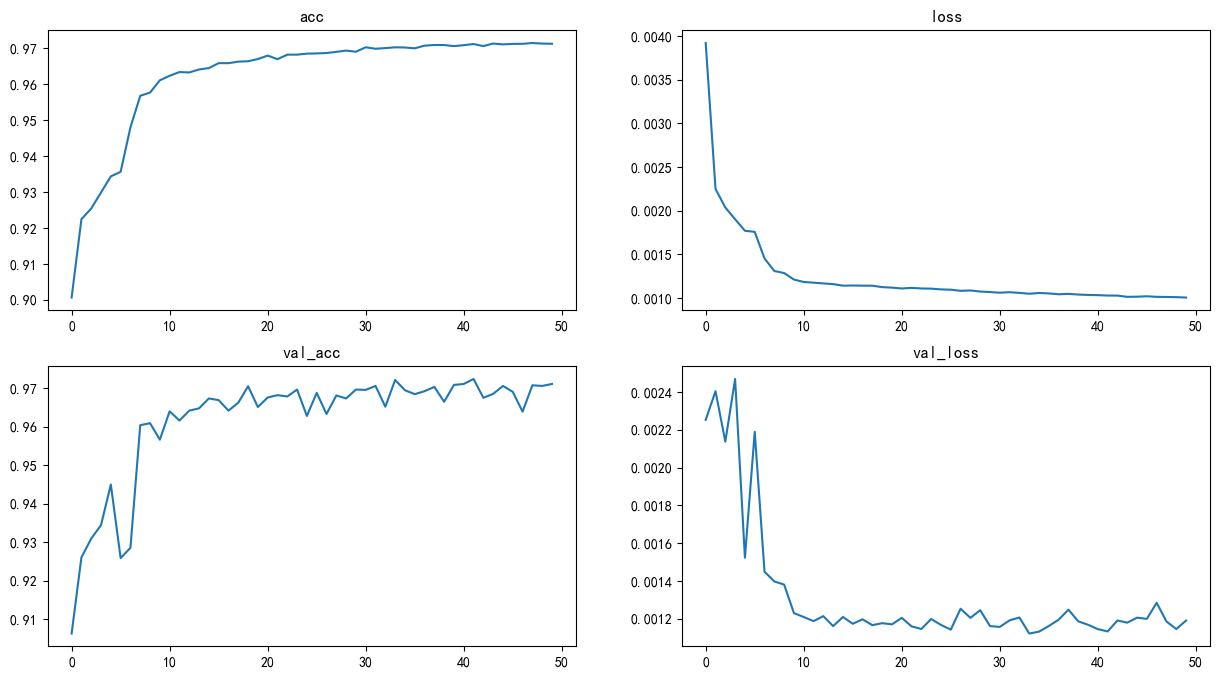

In [10]:
logs = pd.read_csv("./log50炼丹1123.csv")

fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0][0].plot(logs['epoch'],logs['acc'], label='acc')
ax[0][0].set_title('acc')

ax[0][1].plot(logs['epoch'],logs['loss'], label='loss')
ax[0][1].set_title('loss')

ax[1][0].plot(logs['epoch'],logs['val_acc'], label='val_acc')
ax[1][0].set_title('val_acc')

ax[1][1].plot(logs['epoch'],logs['val_loss'], label='val_loss')
ax[1][1].set_title('val_loss')

plt.show()

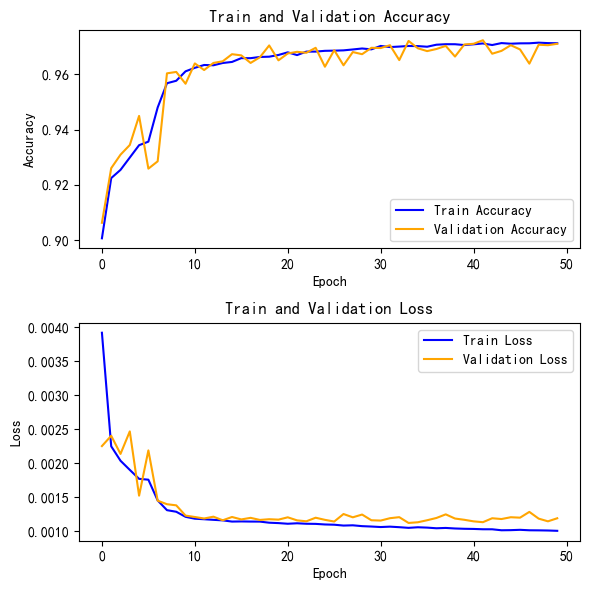

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.read_csv("./log50炼丹1123.csv")

fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# Plot accuracy
ax[0].plot(logs['epoch'], logs['acc'], label='Train Accuracy', color='blue')
ax[0].plot(logs['epoch'], logs['val_acc'], label='Validation Accuracy', color='orange')
ax[0].set_title('Train and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(logs['epoch'], logs['loss'], label='Train Loss', color='blue')
ax[1].plot(logs['epoch'], logs['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Train and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 29ms/step
最大值: 0.04582620444991111
最小值: 0.00282523063042673
均值: 0.019130371355913275
方差: 0.00011541820582519087
标准差: 0.010743286546731911
中位数: 0.01782714391659023


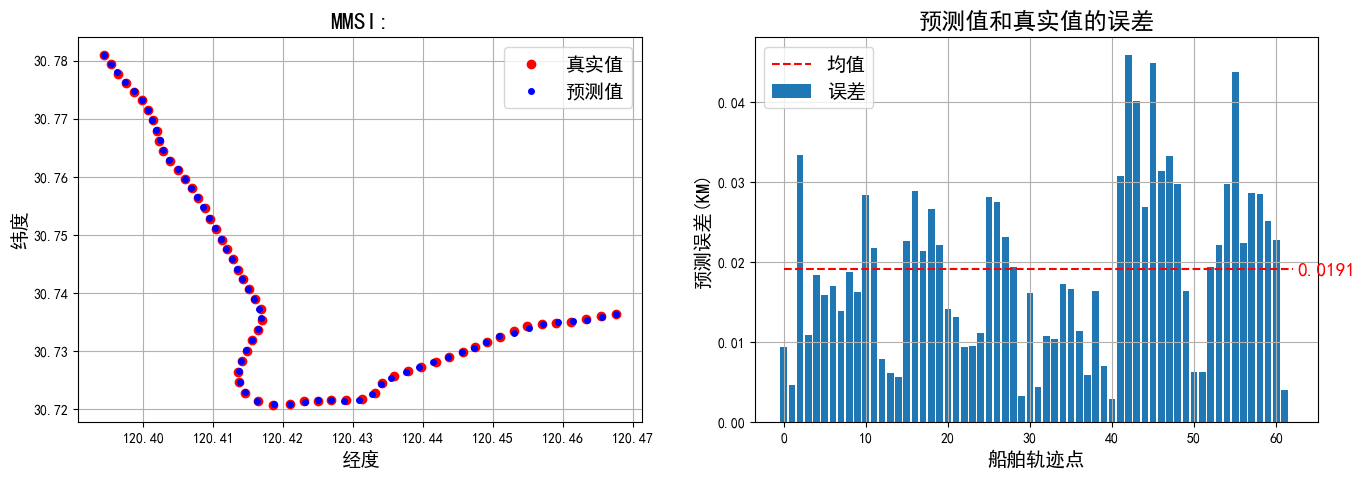

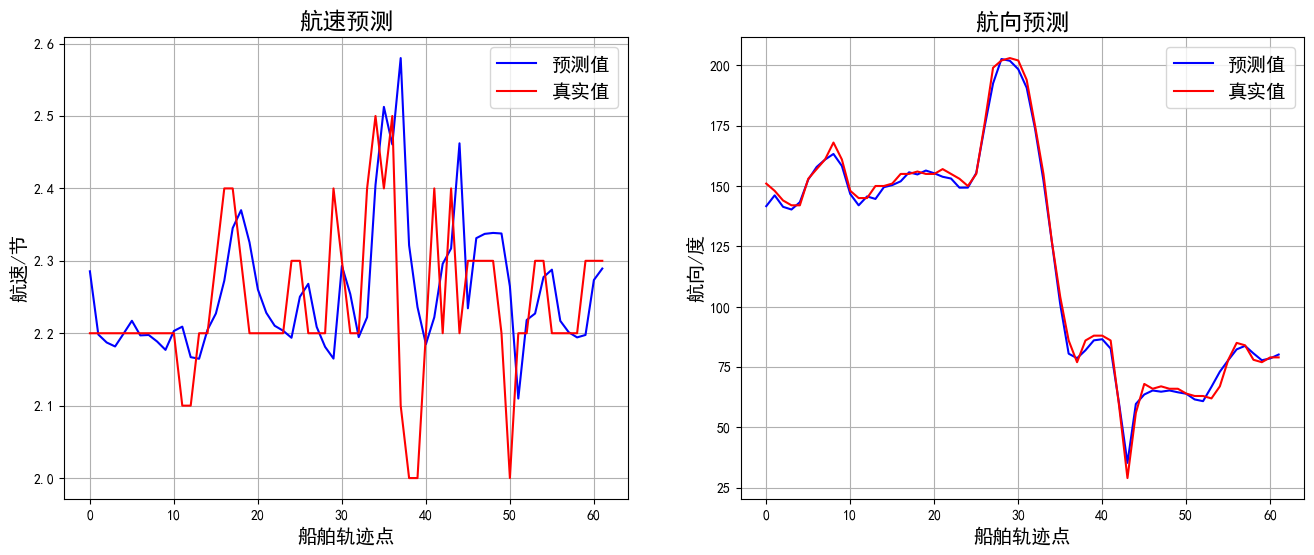

In [11]:
test_points_ids = list(set(test['mmsi']))

for ids in test_points_ids[:1]:
    y_pre = []
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows, maxmin)

    y_true = test_label
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')

    f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

    print(f"最大值: {max(f_y_pre[:, 4])}\n最小值: {min(f_y_pre[:, 4])}\n均值: {np.mean(f_y_pre[:, 4])}\n"
          f"方差: {np.var(f_y_pre[:, 4])}\n标准差: {np.std(f_y_pre[:, 4])}\n中位数: {np.median(f_y_pre[:, 4])}")

    # 画测试样本数据库
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", markersize=6,label='真实值')
    plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo",markersize=4, label='预测值')
#     bounds = [min(f_y_true[:, 0])-0.02,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.02,max(f_y_true[:, 1])+0.01]
#     tbd.plot_map(plt,bounds,zoom = 16,style = 3)
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlabel("经度",fontsize=14)
    plt.ylabel("纬度",fontsize=14)
    plt.title("MMSI:",fontsize=17)

    meanss = np.mean(f_y_pre[:, 4])
    plt.subplot(122)
    plt.bar(range(f_y_pre.shape[0]),f_y_pre[:, 4],label='误差')
    plt.plot([0,f_y_pre.shape[0]],[meanss,meanss],'--r',label="均值")
    plt.title("预测值和真实值的误差",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("预测误差(KM)",fontsize=14)
    plt.text(f_y_pre.shape[0]*1.01,meanss*0.96,round(meanss,4),fontsize=14,color='r')
    plt.grid()
    plt.legend(fontsize=14)

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(f_y_pre[:, 2], "b-", label='预测值')
    plt.plot(f_y_true[:, 2], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航速预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航速/节",fontsize=14)
    plt.grid()

    plt.subplot(122)
    plt.plot(f_y_pre[:, 3], "b-", label='预测值')
    plt.plot(f_y_true[:, 3], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航向预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航向/度",fontsize=14)
    plt.grid()

Processing sequence 0/62
1/1 [==============================] - 0s 29ms/step
Processing sequence 1/62
1/1 [==============================] - 0s 26ms/step
Processing sequence 2/62
1/1 [==============================] - 0s 25ms/step
Processing sequence 3/62
1/1 [==============================] - 0s 25ms/step
Processing sequence 4/62
1/1 [==============================] - 0s 26ms/step
Processing sequence 5/62
1/1 [==============================] - 0s 26ms/step
Processing sequence 6/62
1/1 [==============================] - 0s 28ms/step
Processing sequence 7/62
1/1 [==============================] - 0s 25ms/step
Processing sequence 8/62
1/1 [==============================] - 0s 25ms/step
Processing sequence 9/62
1/1 [==============================] - 0s 25ms/step
Processing sequence 10/62
1/1 [==============================] - 0s 25ms/step
Processing sequence 11/62
1/1 [==============================] - 0s 25ms/step
Processing sequence 12/62
1/1 [==============================] - 0s 25ms/s

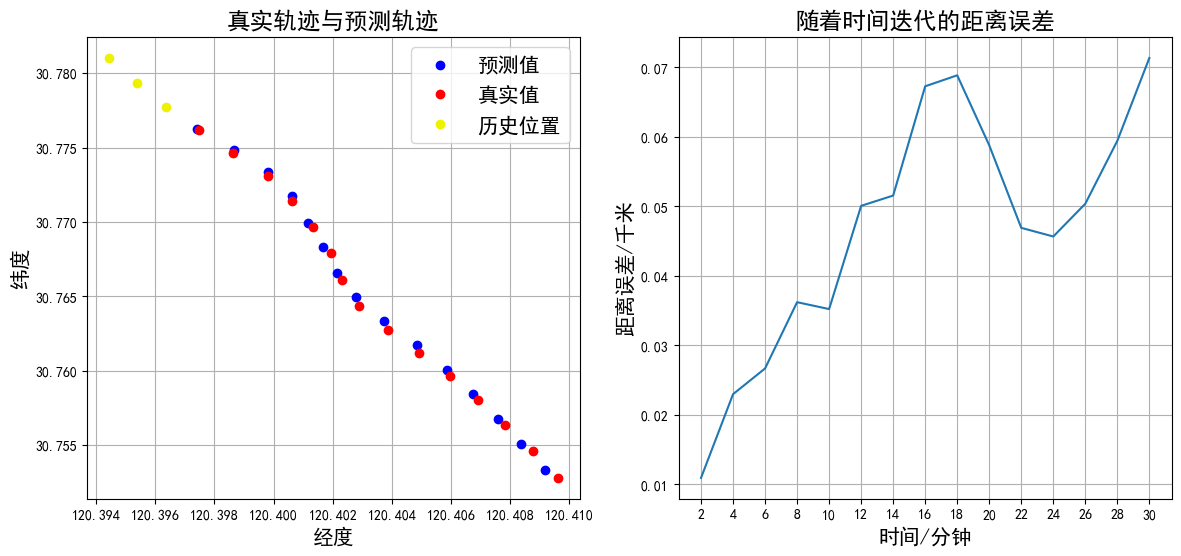

In [12]:
for ids in test_points_ids[:1]:
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows,maxmin)

    y_pre = []
    for i in range(len(test_seq)):
        print(f"Processing sequence {i}/{len(test_seq)}")
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    # 得到真实值
    _,true_lables = FNormalizeMult(y_pre,np.copy(test_label),maxmin)

    for start_id in range(3,4):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        maxStep = min(15,test_seq.shape[0] - start_id)
        # 循环预测
        for i in range(maxStep):
            y_hat = model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)

        plt.figure(figsize=(14,6))
        plt.subplot(121)
        plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo", label='预测值')
        plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", label='真实值')
        plt.plot(true_lables[:start_id, 0], true_lables[:start_id, 1], "o",color='#eef200', label='历史位置')
#         bounds = [min(f_y_true[:, 0])-0.01,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.01,max(f_y_true[:, 1])+0.01]
#         tbd.plot_map(plt,bounds,zoom = 16,style = 3)
        plt.legend(fontsize=15)
        plt.title(f'预测步数量={maxStep},开始位置={start_id}',fontsize=17)
        plt.title(f'真实轨迹与预测轨迹',fontsize=17)
        plt.xlabel("经度",fontsize=15)
        plt.ylabel("纬度",fontsize=15)
        plt.grid()

        plt.subplot(122)
        plt.plot(np.arange(2,2*(maxStep)+1,2),f_y_pre[:,4])
        plt.xticks(np.arange(2,2*(maxStep)+1,2))
        plt.title(f'随着时间迭代的距离误差',fontsize=17)
        plt.xlabel("时间/分钟",fontsize=15)
        plt.ylabel("距离误差/千米",fontsize=15)
        plt.grid()

In [13]:
error_list = []
for ids in test_points_ids[:1]:
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows, maxmin)
    # 要预测的时间
    pre_time = 60
    for start_id in range(test_seq.shape[0]-int(pre_time/2)):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        # 循环预测
        for i in range(int(pre_time/2)):
            y_hat = model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)
        error_list.append(list(f_y_pre[:,4]))

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


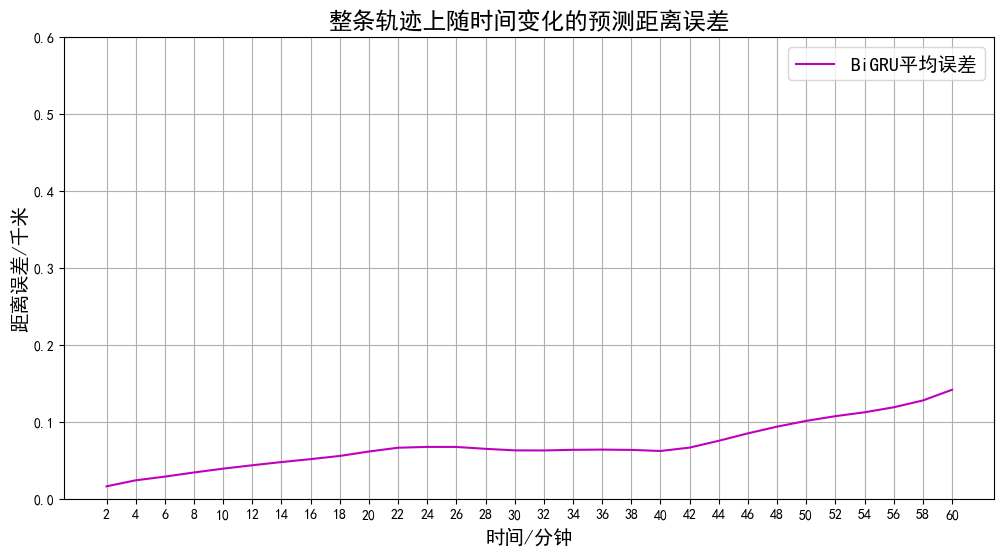

In [14]:
b = np.zeros([len(error_list),len(max(error_list,key = lambda x: len(x)))])
for i,j in enumerate(error_list):
    b[i][0:len(j)] = j

sums = b.sum(axis=0)
maxx = b.max(axis=0)
minx = []
BiGRU_means = []
for col in range(b.shape[1]):
    fzeros = b.shape[0] - list(b[:,col]).count(0.0)
    minx.append(min(list(b[:fzeros,col])))
    BiGRU_means.append(sums[col] / fzeros)

plt.figure(figsize=(12,6))

plt.plot(np.arange(2,2*(b.shape[1])+1,2),BiGRU_means,'-m',label='BiGRU平均误差')
# plt.plot(np.arange(2,2*(b.shape[1])+1,2),minx,'-g',label='最小误差')
# plt.plot(np.arange(2,2*(b.shape[1])+1,2),maxx,'-y',label='最大误差')
plt.xticks(np.arange(2,2*(b.shape[1])+1,2))
plt.yticks(np.arange(0,max(maxx),0.1))
plt.xlabel("时间/分钟",fontsize=14)
plt.ylabel("距离误差/千米",fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title("整条轨迹上随时间变化的预测距离误差",fontsize=17)
plt.savefig('六种模型随时间平均误差对比.png')

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(f_y_true[:, 1], f_y_pre[:, 1])
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(f_y_true[:, 1], f_y_pre[:, 1])
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(f_y_true[:, 1], f_y_pre[:, 1])
print(f"R2分数（R2_score）: {r2}")

平均绝对误差（MAE）: 0.0008096853054850565
均方根误差（RMSE）: 0.0009843032556694942
R2分数（R2_score）: 0.9641101124813766


In [16]:
print(BiGRU_means)

[0.016544615618093863, 0.024363336052879228, 0.029151484227539434, 0.03454753115799835, 0.03950254188937544, 0.043914649134546825, 0.048055600392162626, 0.051867506311418884, 0.055986562111337075, 0.06175945378398073, 0.06668081030634997, 0.06774031542614949, 0.06770977923330006, 0.06523102624378874, 0.06324103087756486, 0.06312429272938379, 0.06395466435416597, 0.06423618251457175, 0.06385630793408816, 0.06243742177159069, 0.06684169488172875, 0.07570153730605621, 0.08535204404130414, 0.09406810924603833, 0.10153682541718857, 0.10767041082418805, 0.11269166500952345, 0.11919074873096115, 0.12805116585612153, 0.14192667021494787]


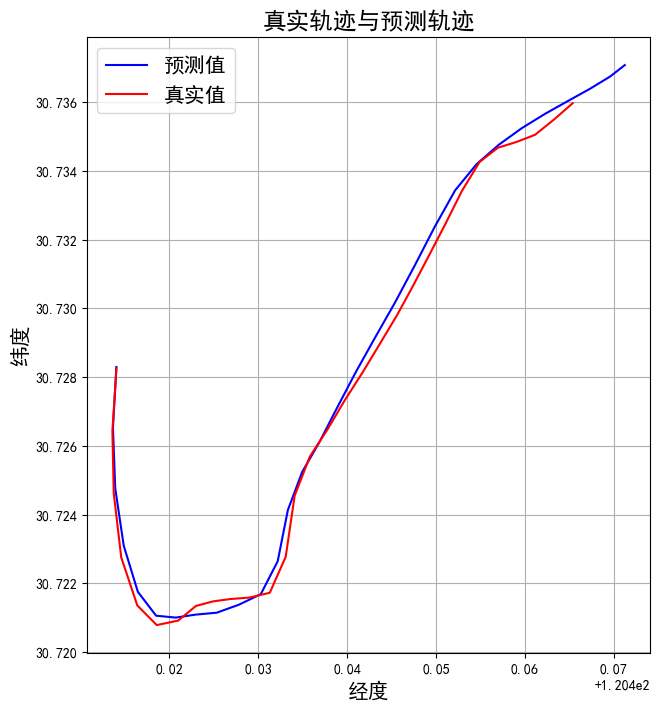

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "-b", label='预测值')
plt.plot(f_y_true[:, 0], f_y_true[:, 1], "-r", label='真实值')
# plt.plot(true_lables[:start_id, 0], true_lables[:start_id, 1], "o",color='#eef200', label='历史位置')
# bounds = [min(f_y_true[:, 0])-0.01,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.01,max(f_y_true[:, 1])+0.01]
# tbd.plot_map(plt,bounds,zoom = 16,style = 3)
plt.legend(fontsize=15)
plt.title(f'预测步数量={maxStep},开始位置={start_id}',fontsize=17)
plt.title(f'真实轨迹与预测轨迹',fontsize=17)
plt.xlabel("经度",fontsize=15)
plt.ylabel("纬度",fontsize=15)
plt.grid()

In [18]:
f_y_pre[:, 0]

array([120.41403445, 120.41365152, 120.41390868, 120.41486356,
       120.41645159, 120.41850676, 120.42071789, 120.4229435 ,
       120.42532014, 120.42781602, 120.43027919, 120.43218109,
       120.43332689, 120.43493412, 120.4368869 , 120.4388713 ,
       120.44097979, 120.44314218, 120.44535712, 120.44758752,
       120.44983661, 120.45214066, 120.45455724, 120.45706755,
       120.45964003, 120.46225986, 120.46487004, 120.46736331,
       120.46956038, 120.4712261 ])

In [19]:
f_y_pre[:, 1]

array([30.7282957 , 30.72651669, 30.72475859, 30.72309312, 30.72175102,
       30.72105519, 30.72100056, 30.72108693, 30.72114259, 30.72137539,
       30.72168222, 30.72263962, 30.72413168, 30.72523983, 30.72611451,
       30.72711286, 30.72815371, 30.72915515, 30.7301628 , 30.73124509,
       30.73237235, 30.73343803, 30.73420187, 30.73476856, 30.73524907,
       30.73566669, 30.73604488, 30.73640339, 30.73674957, 30.73708496])

In [20]:
f_y_true[:, 0]

array([120.4140466 , 120.41358778, 120.41373711, 120.41458015,
       120.41638844, 120.41857742, 120.42099381, 120.42298657,
       120.42493046, 120.42686439, 120.42900787, 120.43129289,
       120.43308444, 120.43409222, 120.43580489, 120.437787  ,
       120.43973486, 120.4417633 , 120.44375333, 120.44562133,
       120.447336  , 120.44914933, 120.45101067, 120.45291733,
       120.45489733, 120.45694566, 120.45903067, 120.461128  ,
       120.46321689, 120.46536   ])

In [21]:
f_y_true[:, 1]

array([30.72825735, 30.72643628, 30.72462322, 30.72275596, 30.72135393,
       30.72078193, 30.7209145 , 30.72133973, 30.72147341, 30.72154076,
       30.72158333, 30.72172328, 30.72277215, 30.7245515 , 30.72569178,
       30.72647891, 30.72733   , 30.72815176, 30.729004  , 30.72981133,
       30.73062511, 30.73151617, 30.73244267, 30.73342867, 30.73426733,
       30.73467796, 30.73484633, 30.73505533, 30.73549067, 30.73597467])